---
**Как работают алгоритм линейной регрессии, алгоритм градиентного спуска, и их реализация в коде, пример с LinearRegression из sklearn на датасете стоимости жилья**

## Ссылки

---
Теория (видео) по линейной регрессии (Stepik)  
https://stepik.org/lesson/83203/step/1?unit=59839

Теория (текст) + задачи по линейной регрессии  
https://stepik.org/lesson/329366/step/1?unit=312669  

МГУ Линейные модели  
https://msu.ai/linear_models

Линейная регрессия и градиентный спуск и Sklearn  
https://pythonru.com/uroki/linear-regression-sklearn  

Линейная регрессия в statsmodels  
https://www.codecamp.ru/blog/linear-regression-python/  

Линейная регрессия Дьяконов  
https://alexanderdyakonov.wordpress.com/2019/10/31/линейная-регрессия/

МНК (Метод наименьших квадратов) с формулами   
https://proproprogs.ru/dsp/metod-naimenshih-kvadratov  
https://python-school.ru/blog/linear-regression-basis/  

Физтех ноутбуки  
https://github.com/girafe-ai/ml-course/tree/master/week0_02_linear_reg  

Интерактивный график линейной регрессии (и не только)  
https://www.desmos.com/calculator/2rnqgoa6a4?lang=ru  
https://www.desmos.com/calculator/utacq3pmng?lang=ru

Интерактивная статья про градиентный спуск
https://rezaborhani.github.io/mlr/blog_posts/Mathematical_Optimization/Part_2_gradient_descent.html  

Аналитическое решение с кодом  
https://habr.com/ru/post/659415/  

Ноутбуки с визуализацией Gradient descent  
https://github.com/hse-ds/iad-intro-ds/blob/master/2023/seminars/sem07_gd/sem07_gd.ipynb  
https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/seminars/sem03-gd.ipynb    
https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem04-gd.ipynb  

---

## Imports

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams.update({'font.size': 10})
# plt.style.use('dark_background')

## LinearRegression Kaggle Dataset

### Kaggle Dataset

Средние цены на жилье в Калифорнии по данным переписи населения 1990 года.  
https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [ ]:
# откатить версию библиотеки kaggle чтобы не было ошибки KeyError: 'username'
!pip install kaggle==1.6.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105787 sha256=8ff0d6b2f239c94a21b757c525e5294232613ea464986d6f292ec1be89638a17
  Stored in directory: /root/.cache/pip/wheels/46/d2/26/84d0a1acdb9c6baccf7d28cf06962ec80529fe1ad938489983
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [ ]:
# датасет будет загружен в виде архива .zip
!kaggle datasets download -d camnugent/california-housing-prices

Dataset URL: https://www.kaggle.com/datasets/camnugent/california-housing-prices
License(s): CC0-1.0
  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 103MB/s]


In [ ]:
# распаковка архива датасета
!unzip california-housing-prices.zip

Archive:  california-housing-prices.zip
  inflating: housing.csv             


Чтение скачанного датасета

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# открыть напрямую с гугл диска
# df = pd.read_csv('https://drive.google.com/uc?export=download&id=1Ykf6l_70jZvZpi1yOVI0NMJk3UGv6iNF')
# df.head()

df = pd.read_csv('/content/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# размерность датасета
df.shape

(20640, 10)

Предобработка датасета

In [ ]:
# типы данных столбцов
df.dtypes

,0
longitude,float64
latitude,float64
housing_median_age,float64
total_rooms,float64
total_bedrooms,float64
population,float64
households,float64
median_income,float64
median_house_value,float64
ocean_proximity,object


In [ ]:
# столбце близость к океану
df.ocean_proximity.value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [ ]:
# выкинуть столбцец ocean_proximity чтобы не возится с преобразованием категориальных значений
# и выкинуть широту и долготу просто для примера
df = df.drop(['ocean_proximity', 'longitude', 'latitude'], axis=1)

In [ ]:
# проверить пропуски в данных
df.isna().sum()

,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0


In [ ]:
# будем менять пропуски на медианые значения соотвествующих столбцов
median_bedrooms = df.total_bedrooms.median(numeric_only=True)
median_bedrooms

435.0

In [ ]:
# заменить nan столбце total_bedrooms значением медианы по этому столбцу
df.total_bedrooms.fillna(median_bedrooms, inplace=True)

/tmp/ipython-input-1898636394.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.total_bedrooms.fillna(median_bedrooms, inplace=True)


In [ ]:
# пропусков больше нет
df.isna().sum()

,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0


In [ ]:
# все столбцы числовые - значит можно подавать в модель
df.dtypes

,0
housing_median_age,float64
total_rooms,float64
total_bedrooms,float64
population,float64
households,float64
median_income,float64
median_house_value,float64


Формирование входных и выходных данных для модели - что будем подавать на вход и что будем предсказывать

In [ ]:
# матрица иксов - признаков - это все кроме последнего столбца
x = df.drop(['median_house_value'], axis=1).to_numpy()

# вектор таргетов - последний столбец, предсказываемое значение цены
y = df[['median_house_value']].to_numpy()

x.shape, y.shape

((20640, 6), (20640, 1))

In [ ]:
# отделяем 30 процентов на тестовую выборку
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=111)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((14448, 6), (6192, 6), (14448, 1), (6192, 1))

Как работает параметр `random_state` - это тоже самое что зафиксировать генератор псевдослучаныйх числе через `np.random.seed()`

In [ ]:
# при каждом запуске разбирвает массив рандомно
train_test_split([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], test_size=0.3)

[[0, 1, 9, 6, 3, 5, 4], [8, 7, 2]]

In [ ]:
# зафиксировать генератор через random_state
train_test_split([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], test_size=0.3, random_state=111)

[[2, 1, 3, 6, 8, 9, 4], [7, 0, 5]]

In [ ]:
# тоже самое через np.random.seed()
np.random.seed(111)

train_test_split([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], test_size=0.3)

[[2, 1, 3, 6, 8, 9, 4], [7, 0, 5]]

### Нормализация данных

Sklearn туториал по нормировке  
https://scikit-learn.ru/6-3-preprocessing-data/  

Руководство по нормализации данных  
https://www.dmitrymakarov.ru/data-analysis/transform-08/

Почему `fit_transform` нельзя применять на тестовой выборке  
https://stackoverflow.com/questions/43675665/when-scale-the-data-why-the-train-dataset-use-fit-and-transform-but-the-te  
https://datascience.stackexchange.com/questions/12321/whats-the-difference-between-fit-and-fit-transform-in-scikit-learn-models/

Почему нормализацию делают после разделения на train test (утечка данных)  
https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split

Чтобы значения столбцов не были огромными и не были в разных шкалах - деллаем их нормировку - приведение к одному масштабу (нормализация, стандартизация)

Ниже приведен разбор нормировки с использованием двух разных алгоритмов

#### StandardScaler  
[doc](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

StandardScaler делает у распределения параметры среднее 0 и стандартное отклонение 1 - делает стандартизацию данных

In [ ]:
# для нормировки данные должны быть как минимум 2-мерные
x_train.shape

(14448, 6)

`fit` вычичисляет и запоминает значения `mean` и `std`, `transform` делает само нормирование - вычитает среднее `mean` и делит на стандартное отклонение `std`  
`fit_transform` делает все сразу - запоминает статистики и применяет их к данным   
На выходе получается распределение со средним 0 и стандартным отклонением 1

In [ ]:
# объект который будет делать нормировку
scaler_x = StandardScaler()

# нормировка x_train с запоминанем в scaler_x статистик среднего и стандартного отклонения
x_train_scaled = scaler_x.fit_transform(x_train)

# нормировка x_test с использованием статистик посчитанных на выборке x_train
# к текстовым данным нужно применять transform а не fit_transform
x_test_scaled = scaler_x.transform(x_test)


# тоже самое для y если хотим их нормировать (y не всегда нормируют)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:
# минимальные и максимальные значения после нормировки
x_train_scaled.min(), x_train_scaled.max()

(np.float64(-2.1837235362121894), np.float64(29.701664253537963))

In [ ]:
x_train.shape

(14448, 6)

До нормализации

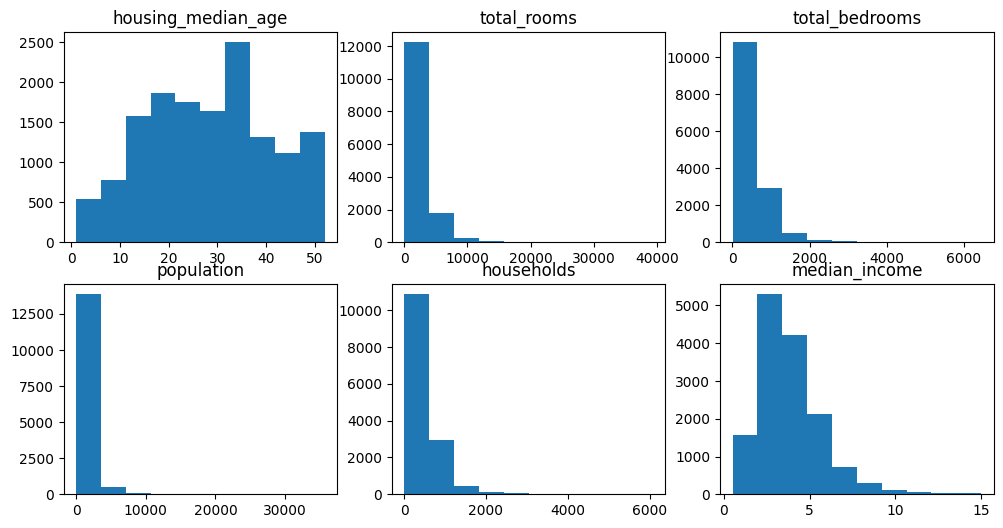

In [ ]:
plt.figure(figsize=(12, 6))

for i in range(len(df.columns[:-1])):
    plt.subplot(2, 3, i + 1)
    plt.title(df.columns[i])
    plt.hist(x_train[:, i])

plt.show()

После нормализации

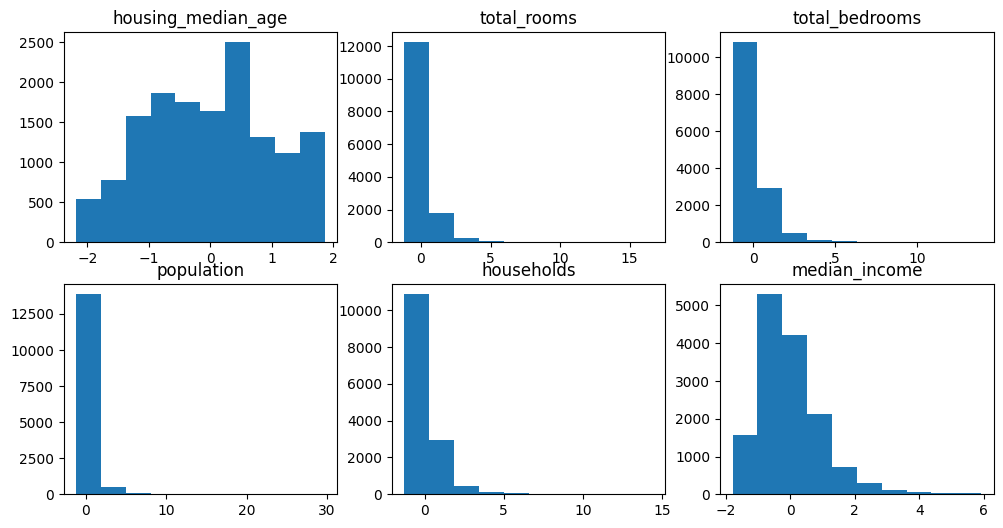

In [ ]:
plt.figure(figsize=(12, 6))

for i in range(len(df.columns[:-1])):
    plt.subplot(2, 3, i + 1)
    plt.title(df.columns[i])
    plt.hist(x_train_scaled[:, i])

plt.show()

Как StandardScaler работает под капотом

In [ ]:
# scaler расчитывает и запоминает значения mean и std
scaler_x.mean_, scaler_x.scale_

(array([  28.5559247 , 2646.21767719,  539.55931617, 1430.50616002,
         501.59004707,    3.85735885]),
 array([1.26187790e+01, 2.20055989e+03, 4.24249466e+02, 1.15318433e+03,
        3.86693998e+02, 1.88258360e+00]))

In [ ]:
# значения mean и std
x_train.mean(axis=0), x_train.std(axis=0)

(array([  28.5559247 , 2646.21767719,  539.55931617, 1430.50616002,
         501.59004707,    3.85735885]),
 array([1.26187790e+01, 2.20055989e+03, 4.24249466e+02, 1.15318433e+03,
        3.86693998e+02, 1.88258360e+00]))

In [ ]:
# нормированные значения через StandardScaler
x_test_scaled[0]

array([-0.20254929, -0.96939769, -0.47509622, -0.196418  , -0.46701022,
       -1.25729282])

In [ ]:
# нормировка вручную
x_train_scaled = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)

# для нормирования тестовой выбрки используется mean и std из тренировочной
x_test_scaled = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0)

In [ ]:
# нормированные значения вручную
x_test_scaled[0]

array([-0.20254929, -0.96939769, -0.47509622, -0.196418  , -0.46701022,
       -1.25729282])

In [ ]:
# преобразовать нормированные данные к изначальным значениям через inverse_transform
scaler_x.inverse_transform(x_test_scaled)[0]

array([  26.    ,  513.    ,  338.    , 1204.    ,  321.    ,    1.4904])

In [ ]:
# inverse_transform вручную
(x_test_scaled * x_train.std(axis=0) + x_train.mean(axis=0))[0]

array([  26.    ,  513.    ,  338.    , 1204.    ,  321.    ,    1.4904])

In [ ]:
# реальные данные до нормировки
x_test[0]

array([  26.    ,  513.    ,  338.    , 1204.    ,  321.    ,    1.4904])

#### MinMaxScaler  
[doc](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

MinMaxScaler приводит максимум и минимум к диапазону 0 - 1

Вычитает из каждого значения минимальное значение выборки, и делит на разницу между максимальным и минимальным  
На выходе диапазон `[0 - 1]` (или можно сделать любой диапазон с помощью параметра `feature_range=(min, max)`)

In [ ]:
scaler = MinMaxScaler()  # feature_range=(-1, 1)

# нормировка x_train с запоминанем в scaler_x статистик среднего и стандартного отклонения
x_train_scaled = scaler.fit_transform(x_train)

# нормировка x_test с использованием статистик посчитанных на выборке x_train
x_test_scaled = scaler.transform(x_test)

In [ ]:
# минимальные и максимальные значения
x_train_scaled.min(), x_train_scaled.max()

(np.float64(0.0), np.float64(1.0000000000000002))

До нормализации

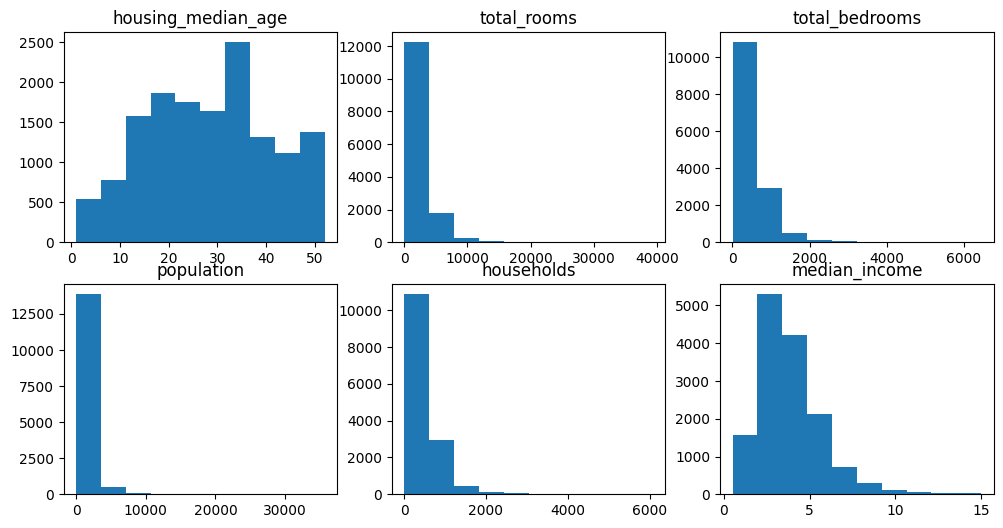

In [ ]:
plt.figure(figsize=(12, 6))

for i in range(len(df.columns[:-1])):
    plt.subplot(2, 3, i + 1)
    plt.title(df.columns[i])
    plt.hist(x_train[:, i])

plt.show()

После нормализации

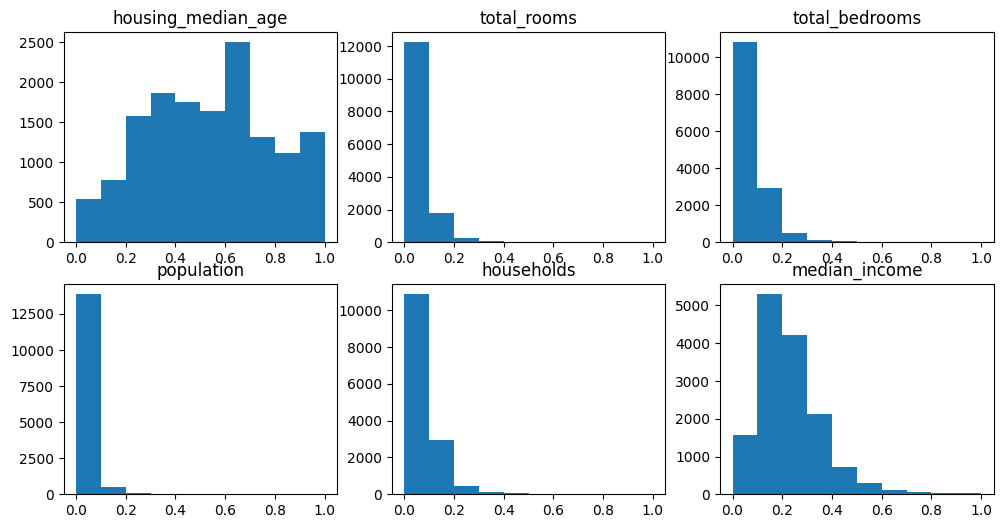

In [ ]:
plt.figure(figsize=(12, 6))

for i in range(len(df.columns[:-1])):
    plt.subplot(2, 3, i + 1)
    plt.title(df.columns[i])
    plt.hist(x_train_scaled[:, i])

plt.show()

Как MinMaxScaler работает под капотом

In [ ]:
# нормированные данные
x_train_scaled[0]

array([0.70588235, 0.03029147, 0.03150706, 0.01359343, 0.03651316,
       0.21552117])

In [ ]:
# нормировка вручную по формуле:
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

x_train_scaled = (x_train - x_train.min(axis=0)) / (x_train.max(axis=0) - x_train.min(axis=0))
x_train_scaled[0]

array([0.70588235, 0.03029147, 0.03150706, 0.01359343, 0.03651316,
       0.21552117])

In [ ]:
# преобразовать нормированные данные к изначальным значениям через inverse_transform
scaler_x.inverse_transform(x_train_scaled)[0]

array([  37.46329811, 2712.87587013,  552.92617036, 1446.18189087,
        515.70946606,    4.26309546])

In [ ]:
# преобразовать нормированные данные к изначальным значениям вручную
# X_scaled = X_std * (max - min) + min
inverse = x_train_scaled * (x_train.max(axis=0) - x_train.min(axis=0)) + x_train.min(axis=0)
inverse[0]

array([  37.   , 1193.   ,  205.   ,  488.   ,  224.   ,    3.625])

In [ ]:
# реальные данные до нормировки
x_train[0]

array([  37.   , 1193.   ,  205.   ,  488.   ,  224.   ,    3.625])

### Sklearn LinearRegression

Обучение на не нормированных данных

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# создание экземпляра модели
model = LinearRegression()

# обучение - нахождение оптимальных w и b
model.fit(x_train, y_train)

# model.score вычисляет R2 метрику (коэффициент детерминации) для большинства моделей регрессии
r2 = model.score(x_test, y_test)

print(f'Коэффициенты w: {model.coef_}')
print(f'Смещение bias: {model.intercept_}')
print(f'Коэффициент детерминации R2: {r2}')

Коэффициенты w: [[ 1.86523883e+03 -2.00222966e+01  8.66548830e+01 -3.46586336e+01
   1.38859053e+02  4.81153269e+04]]
Смещение bias: [-46495.98704188]
Коэффициент детерминации R2: 0.5588699629730516


Метрики качества

In [ ]:
# сделать предсказание моделью на тестовых данных (y = w * x + b)
y_pred = model.predict(x_test)
y_pred.shape

(6192, 1)

In [ ]:
# расчет R2 вручную (коэффициент детерминации)
r2 = 1 - np.sum((y_pred - y_test)**2) / np.sum((y_test - y_test.mean())**2)
r2

np.float64(0.5588699629730516)

In [ ]:
# R2 через функцию из sklearn
metrics.r2_score(y_test, y_pred)

0.5588699629730516

In [ ]:
# расчет MSE вручную
mse = ((y_test - y_pred)**2).mean()
mse

np.float64(5938431134.909925)

In [ ]:
# MSE через функцию из sklearn
metrics.mean_squared_error(y_test, y_pred)

5938431134.909925

Получить предсказание модели на новых данных (инференс модели)

In [ ]:
# просмотр столбцов на которых обучали модель
df.head(1)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0


In [ ]:
# создать новый объект дом с характеристиками, кроме предсказываемой median_house_value
new_data = np.array([
    [40., 880., 129., 322., 126., 8.],
    # ... здесь могут быть и другие объекты если хотим предсказать сразу несколько
    ])

# предсказание median_house_value для нового дома
y_pred = model.predict(new_data)
y_pred

array([[412931.20121751]])

In [ ]:
# сделать инференс вручную (y = wx + b)
y_pred = new_data @ model.coef_.T + model.intercept_
y_pred

array([[412931.20121751]])

Определение важности признаков в датасете  
Отрисовка влияния каждого признака на выход модели - чем больше коэффициент по модулю тем соответствующий признак сильнее влияет на таргет переменную

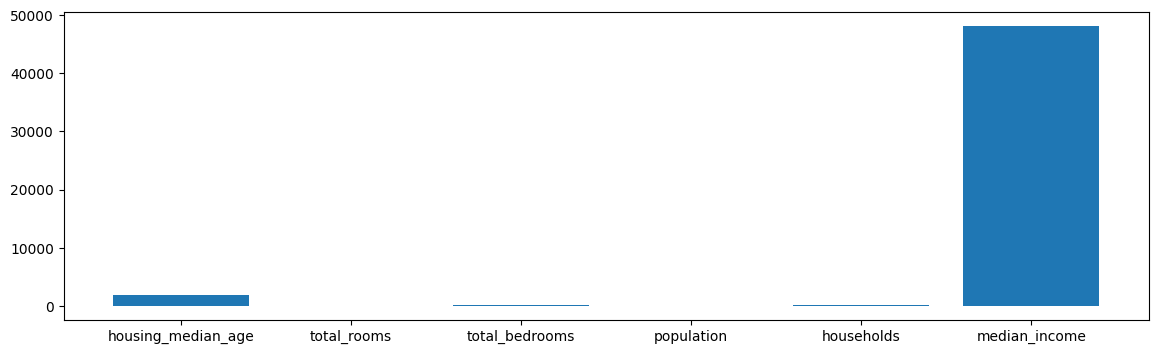

In [ ]:
# данные не нормированы поэтому такая разница
plt.figure(figsize=(14, 4))
plt.bar(df.columns[:-1], model.coef_[0])
plt.show()

Обучим еще раз линейную регрессию, теперь на нормированных данных и сравним найденные параметры с теми что вычислим по формуле ниже

Аналитическое решение для линейной регрессии:

<font size="5">
\begin{align}
\Theta = (X^T X)^{-1} X^T y
\end{align}
</font>

In [ ]:
# StandardScaler для нормировки данных
scaler_x = StandardScaler()

# fit_transform делает и fit и transform - вычисляет статистики среднее и стандартное отклонение x_train и нормирует x_train
# нормирует (масштабирует, нормализация) - то есть вычитает среднее и делит на стандартное отклонение
# то есть приводит x_train к стандартному распределению со средним 0 и std 1
x_train_scaled = scaler_x.fit_transform(x_train)

# transform берет посчитанные на этапе fit статистики и применяет их - приводит x_test к стандартному распределению
x_test_scaled = scaler_x.transform(x_test)


# создание экземпляра модели
model = LinearRegression()

# обучаем регрессию на нормированных данных
model.fit(x_train_scaled, y_train)

# model.score вычисляет R2 метрику
r2 = model.score(x_test_scaled, y_test)

print('Коэффициенты w: ', model.coef_)
print('Смещение bias: ', model.intercept_)
print(f'Коэффициент детерминации R2: {r2}')

Коэффициенты w:  [[ 23537.03659501 -44060.26276255  36763.2878124  -39967.79319897
   53695.96219517  90581.12553453]]
Смещение bias:  [206208.73906423]
Коэффициент детерминации R2: 0.5588699629730517


In [ ]:
# расчет весов model.coef_ через формулу
# если нужно вычислить значение b то надо заранее дополнить данные и веса единичными столбцами
coef_matrix = np.dot(np.dot(np.linalg.inv(np.dot(x_train_scaled.T, x_train_scaled)), x_train_scaled.T), y_train)
coef_matrix

array([[ 23537.03659501],
       [-44060.26276254],
       [ 36763.2878124 ],
       [-39967.79319897],
       [ 53695.96219517],
       [ 90581.12553453]])

Определение важности признаков в датасете  
Отрисовка влияния каждого признака на выход модели - чем больше коэффициент по модулю тем соответствующий признак сильнее влияет на таргет переменную

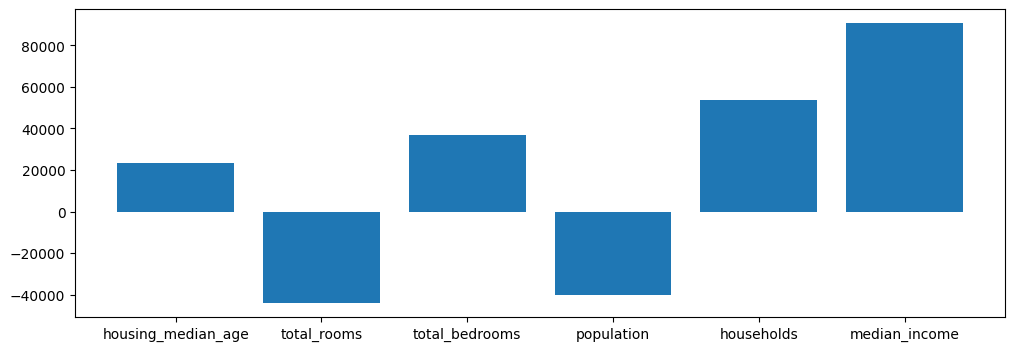

In [ ]:
plt.figure(figsize=(12, 4))
plt.bar(df.columns[:-1], model.coef_[0])
plt.show()

## Gradient descent

Как найти минимум функции с помощью алгоритма градиентного спуска  
**Все примеры далее в этом ноутбуке созданы для демонстрации как это работет под капотом - на практике все уже реализовано и такой код писать не придется**

### Линейная регрессия с одним параметром

Линейная регрессия `y = wx` с одним параметром `w`, который отвечает за угол наклона прямой

#### Нахождение минмума простой функции

Найти минимум функции $y = 2x^2$  
Найти такой `x`, при котором `y` примет минимальное значение

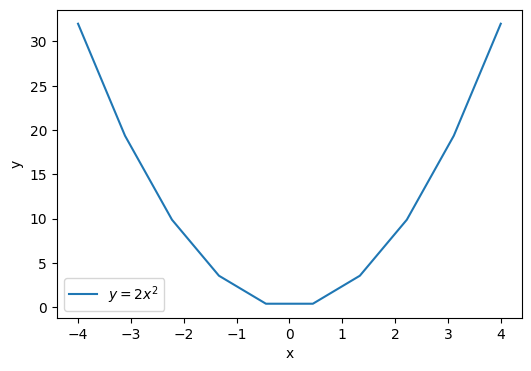

In [ ]:
# массив множества иксов чтобы отобразить на графике как иксы преобразуются в игреки через нашу функцию
X = np.linspace(-4, 4, 10)

# формула функции для игреков
Y = 2 * X**2

# отрисовка функции на графике
plt.plot(X, Y, label='$y = 2x^2$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Производная покажет насколько сильно возрастает или убывает функция в произвольной точке `x`  
То есть с какой скоростью возрастет или уменьшится значение `y` при малейшем увеличении `x`

Точка x: 2, Точка y: 8, Производная dy_dx: 8


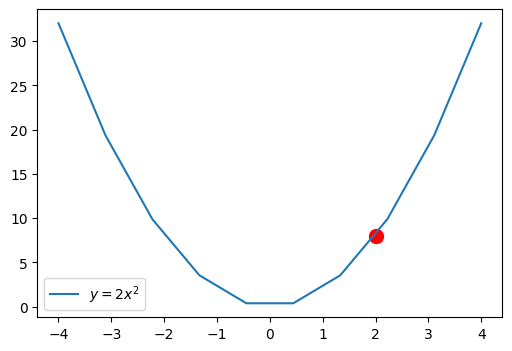

In [ ]:
# значение x в рандомной точке
x = 2
# значение y в этой точке
y = 2 * x**2
# производная функции y = 2 * x**2 равна 4 * x (по таблице производных)
dy_dx = 4 * x

print(f'Точка x: {x}, Точка y: {y}, Производная dy_dx: {dy_dx}')
plt.plot(X, Y, label='$y = 2x^2$')
plt.scatter(x, y, c='r', s=100)
plt.legend()
plt.show()

Сделать шаг градиентного спуска  
Для корректировки `x` нужно из `x` вычесть производную, домноженную на маленький коэффициент (скорость обучения, learning rate) 0 < LR < 1  
Это называется сделать шаг градиентного спуска - изменить обучаемый параметр так чтобы значение `y` стремилось к своему минимуму

Точка x: 1.2, Точка y: 2.88, Производная dy_dx: 4.8


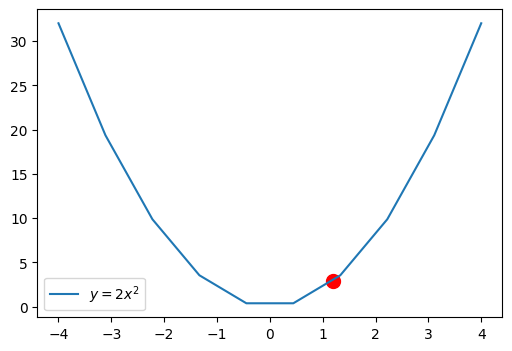

In [ ]:
# задать скорость обучения - насколкьо сильно нам нужно корректировать x в сторону минимизации функции
lr = 0.1
# корректировка x на значение производной, домноженное скорость обучения (шаг градиентного спуска)
x = x - lr * dy_dx
# новое значение y
y = 2 * x**2
# новое значение производной для обновленной точки x
dy_dx = 4 * x

print(f'Точка x: {x}, Точка y: {y}, Производная dy_dx: {dy_dx}')
plt.plot(X, Y, label='$y = 2x^2$')
plt.scatter(x, y, c='r', s=100)
plt.legend()
plt.show()

Еще один шаг градиентного спуска

Точка x: 0.72, Точка y: 1.0368, Производная dy_dx: 2.88


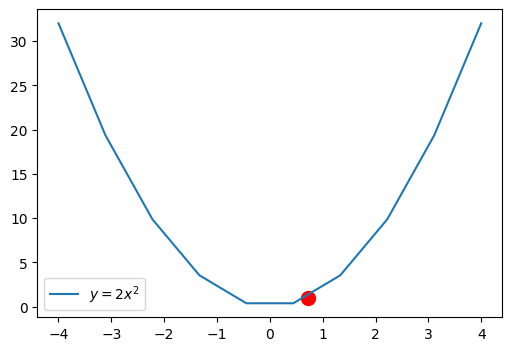

In [ ]:
x = x - lr * dy_dx  # корректировка x
y = 2 * x**2
dy_dx = 4 * x

print(f'Точка x: {x}, Точка y: {y}, Производная dy_dx: {dy_dx}')
plt.plot(X, Y, label='$y = 2x^2$')
plt.scatter(x, y, c='r', s=100)
plt.legend()
plt.show()

Сделать 10 шагов градиентного спуска в цикле сначала

Точка x: -0.02, Точка y: 0.00, Производная dy_dx: -0.12


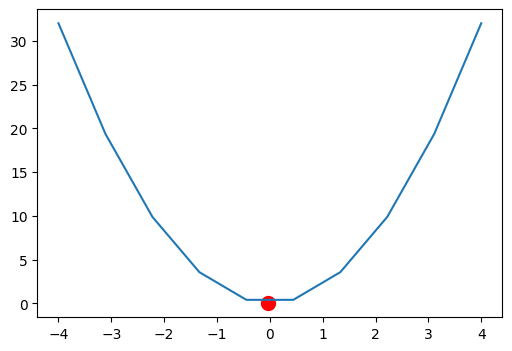

In [ ]:
# список для визуализации x и y
dots = []
# начальное значение x - любое рандомное число
x = -3
# 10 эпох обучения
for _ in range(10):
    # расчет текущего значения y
    y_pred = 2 * x**2
    # обновления списка точек для визуализации
    dots.append([x, y_pred])
    # расчет производной функции y=2x**2 для текущей точки x
    dy_dx = 4 * x
    # корректировка x (шаг градиентного спуска)
    x -= 0.1 * dy_dx

    print(f'Точка x: {x:.2f}, Точка y: {y_pred:.2f}, Производная dy_dx: {dy_dx:.2f}')

    # отрисовка на графике
    plt.plot(X, Y)
    plt.scatter(dots[-1][0], dots[-1][-1], c='r', s=100)
    plt.show()
    clear_output(True)
    time.sleep(0.3)

Отрисока динамики изменения `x` и `y`

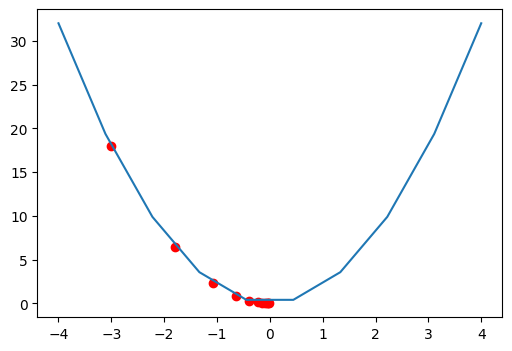

In [ ]:
dots = np.array(dots)
plt.scatter(dots[:, 0], dots[:, 1], c='r')
plt.plot(X, Y)
plt.scatter(x, y_pred, c='r')
plt.show()

#### Задача про прибор

Есть прибор, который получает на вход одни данные `X` (числа, какие нибудь измерения) и выдает на выходе другие данные `y` - какие либо важные для нас показатели  
Как прибор работает внутри неизвестно - функция, по которой из `X` получаются `y` нам недоступна  
Хотим создать такой же прибор с помощью математики - приблизить неизвестную нам функцию своей самописной функцией, например по формуле уравнения прямой `y = w * X`  
Здесь обучаемый параметр `w` (вес) будет выступать в роли прибора - получать на вход `X` и выдавать `y_pred` - предсказания нашего прибора  

Задача:  
Найти такой вес `w` с помощью градиентного спуска, умножив на который `X` мы получим такие значения `y_pred`, которые будут максимально похожи на `y` которые нам выдает неизвестный прибор  

Алгоритм:  
Возьмем произвольный массив с реальными данными `X` - подадим их на вход неизвестному прибору и получим массив `y` - это идеальные значения `y` которые мы хотим научиться сами получать  
Затем создадим свой прибор - какой либо случайный вес `w`, и получим свои значения `y_pred` по формуле `y_pred = X * w` - предсказания нашей модели линейной регрессии  
И посчитаем разницу между идеальными значениями `y` и теми что мы получили с помощью своего прибора `y_pred`  - эта разница покажет нам ошибку - насколько ошибается наш прибор от идеального  
Остается только минимизировать получивнуюся функцию ошибки с помощью градиентного спуска

In [ ]:
# функция которая является прибором - по условию задачи мы не знаем что происходит внутри нее
def device(x):
    np.random.seed(111)
    # неизвестное нам число на основе которого работает прибор
    T = np.random.uniform(1, 5)
    # для упрощения представим что прибор работает по простейшей формуле
    return T * x

# например для значения x = 5 прибор выдает такой выход
device(5)

17.243403512352373

In [ ]:
# для значения x = -3 прибор выдает такой ответ
device(-3)

-10.346042107411424

Подадим на вход прибору набор разных `X` и получим идеальные предсказания прибора

In [ ]:
# массив x чтобы посчитать для них значения y
X = np.arange(-10, 10)
# посчитать значения y
y = device(X)
y

array([-34.48680702, -31.03812632, -27.58944562, -24.14076492,
       -20.69208421, -17.24340351, -13.79472281, -10.34604211,
        -6.8973614 ,  -3.4486807 ,   0.        ,   3.4486807 ,
         6.8973614 ,  10.34604211,  13.79472281,  17.24340351,
        20.69208421,  24.14076492,  27.58944562,  31.03812632])

Отрисуем на графике функцию прибора - график функции преобразования из `X` в `y`

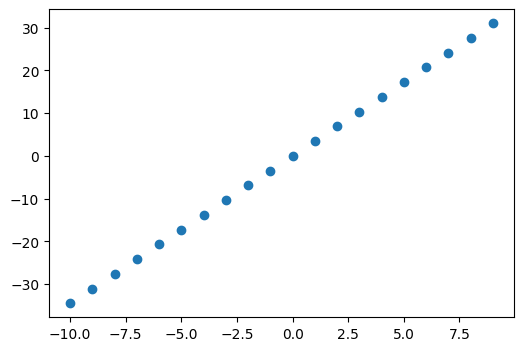

In [ ]:
# отобразить на графике значения прибора
plt.scatter(X, y);

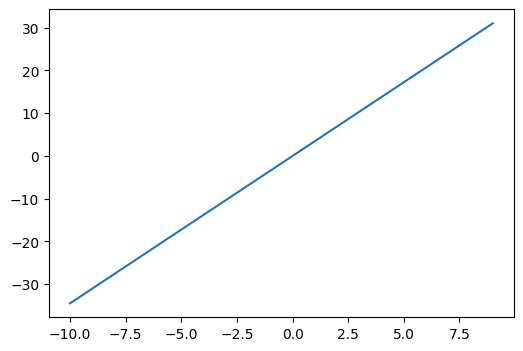

In [ ]:
# если точек взять бесчконечное кол-во то получится непрерывная линия
# это закон по которому прибор порождает выходные данные
plt.plot(X, y);

Создаем свой прибор со случайным значением `w` и применим его к даннм  
Задача - найти число `w` - коэффициент наклона прямой, попробуем наугад `w` = 3

In [ ]:
w = 6
# наш самодельный прибор - линейная регресия - уравнение прямой y = w * x (пример без смещения b)
y_pred = w * X
y_pred

array([-60, -54, -48, -42, -36, -30, -24, -18, -12,  -6,   0,   6,  12,
        18,  24,  30,  36,  42,  48,  54])

Отобразим на графике разницу между неизвестным прибором и нашим

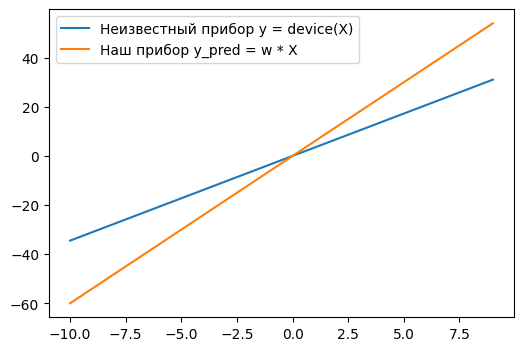

In [ ]:
plt.plot(X, y, label='Неизвестный прибор y = device(X)')
plt.plot(X, y_pred, label='Наш прибор y_pred = w * X')
plt.legend()
plt.show()

Посмотрим насколько наш прибор ошибается  
Функция ошибки - считаем насколько наша модель при весе `w = 3` ошибается от значений на выходе неизвестного прибора  
Квадратичная ошибка - сумма квадратов ошибок для каждого значения

In [ ]:
# разница между предсказаниями неизвестного прибора и нашего для каждой точки в квадрате
loss = (y - y_pred) ** 2
loss

array([650.92301579, 527.24764279, 416.59073011, 318.95227774,
       234.33228569, 162.73075395, 104.14768253,  58.58307142,
        26.03692063,   6.50923016,   0.        ,   6.50923016,
        26.03692063,  58.58307142, 104.14768253, 162.73075395,
       234.33228569, 318.95227774, 416.59073011, 527.24764279])

Чтобы эта ошибка была одним числом, вычислем среднее всех ошибок - получится Среднеквадратичная ошибка (`MSE`)

In [ ]:
# MSE - сумма всех квадратичных ошибок поделить на их кол-во
loss.sum() / len(loss)

np.float64(218.05921029120947)

In [ ]:
# тоже самое
loss.mean()

np.float64(218.05921029120947)

Остается минимизировать функцию ошибки `MSE` с помощью градиентного спуска - изменять в цикле обучаемый параметр (вес) нашего прибора `w`, чтобы ошибка между `y` из неизвестного прибора и `y_pred` нашего была минимальна  

Производная функции ошибки показывает, насколько значение этой функции (среднеквадратичной ошибки в данном примере) растет или падает при изменении весов `w`

Значения производных для функции ошибки MSE, когда модель имеет 2 параметра `w1 * x + w0`
<img src="https://drive.google.com/uc?export=view&id=1pkigRI15LkhBPtIR1huMJjyKHvHhXe4G" width=50%>

Источник  
https://cs.hse.ru/data/2017/11/21/1160780232/Slides-IntroToAI-HSE-2017-06-2-Panov.pdf

В нашем случае параметр один - `w * x`

Функция ошибки MSE в общем виде  
$MSE = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2$

Получение предсказаний модели (линейная регрессия с параметрами `w` и `b`)  
$\hat{y}_i = wx_i + b$

Функция ошибки MSE которую нужно минимизировать  
$MSE = \frac{1}{n} \sum_{i=1}^n ((wx_i + b) - y_i)^2$

Производная по параметру `w`  
$\frac{\partial MSE}{\partial w} = \frac{2}{n} \sum_{i=1}^n [x_i((wx_i + b) - y_i))]$

Производная по параметру `b`  
$\frac{\partial MSE}{\partial b} = \frac{2}{n} \sum_{i=1}^n ((wx_i + b) - y_i)$

In [ ]:
# производная находится с помощью таблицы и правил нахождения производных
# положительная производная говорит нам что при увеличении w значение loss будет увеличиваться
# значит нам нужно наоборот уменьшать w чтобы уменьшать loss

# то же самое
# dy_dw = 2 * (np.sum((w * x - y) * X)) / len(y)

dy_dw = 2 * (np.sum((y_pred - y) * X)) / len(y)
dy_dw

np.float64(170.93839293447817)

Шаг градиентного спуска - изменить текущее значение веса `w` на значение производной, домноженное на маленький коэффициент (скорость обучения, learning rate, нужен для того чтобы не делать большие шаги и не проскочить минимум функции потерь)

In [ ]:
# скорость обучения
learning_rate = 0.01
# шаг градиентного спуска
new_w = w - learning_rate * dy_dw

# новое значение для веса w
print(f'Старое значение параметра w: {w}')
print(f'Новое значение параметра w: {new_w}')

Старое значение параметра w: 6
Новое значение параметра w: 4.2906160706552186


Проверим как отличаются графики неизвестного прибора и нашего обновленного с новым параметром `w`

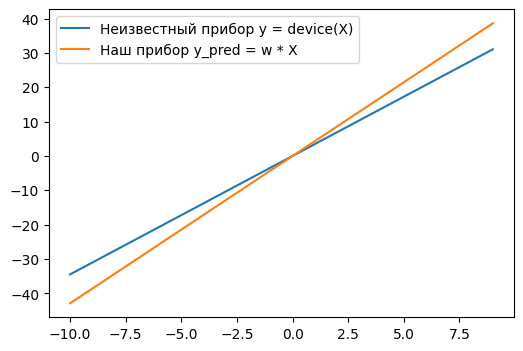

In [ ]:
# делаем предсказание обновленным прибором
y_pred = new_w * X

# отрисовка графиков
plt.plot(X, y, label='Неизвестный прибор y = device(X)')
plt.plot(X, y_pred, label='Наш прибор y_pred = w * X')
plt.legend()
plt.show()

Построим функцию ошибки для множества возможных весов `w`, например в диапазоне от -10 до 10

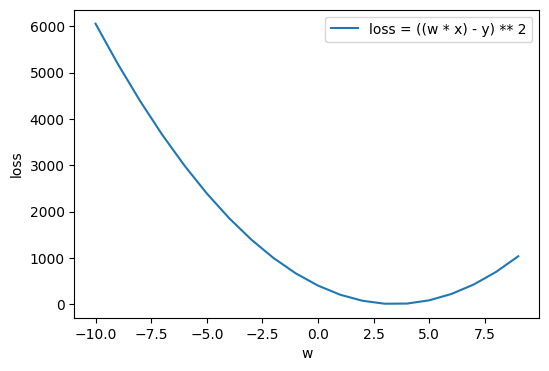

In [ ]:
w_range = np.arange(-10, 10)
lossess = []
for w in w_range:
    # расчет ошибки MSE для каждого w из диапазона
    loss = ((w * X) - y) ** 2
    lossess.append(loss.mean())

plt.plot(w_range, lossess, label='loss = ((w * x) - y) ** 2')
plt.xlabel('w')
plt.ylabel('loss')
plt.legend()
plt.show()

Примерно видим точку весов `w`, при которой ошибка минимальна, теперь найдем ее с помощью алгоритма градиентного спуска в цикле

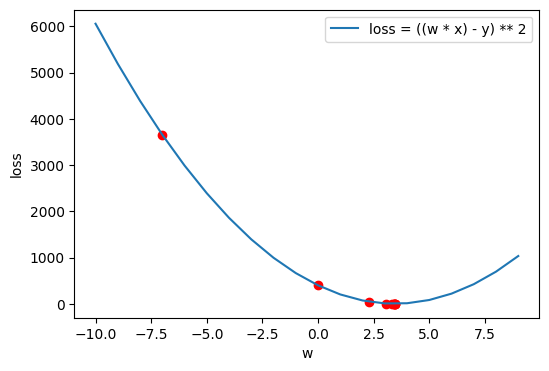

In [ ]:
losses = []  # массив для ошибок
dots = []  # массив для w
w = -7  # начальное значение w

learning_rate = 0.01  # скорость обучения

# количество эпох обучения
EPOHS = 10

for i in range(EPOHS):
    # обновить массив для w
    dots.append(w)
    # расчет ответов модели с текущим весом w
    y_pred = w * X

    # ошибка модели с обновленным значением веса w
    loss = ((y_pred - y) ** 2).mean()
    losses.append(loss)

    # производная функции ошибки
    dy_dw = 2 * (np.sum((y_pred - y) * X)) / len(y)
    # корректировка весов
    w = w - learning_rate * dy_dw  # корректировка веса

# отрисовка на графике
plt.plot(w_range, lossess, label='loss = ((w * x) - y) ** 2')
plt.scatter(dots, losses, color='red')
plt.xlabel('w')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# как уменьшалось значение ошибок в процессе обучения
losses

[np.float64(3657.360102142993),
 np.float64(398.2865151233718),
 np.float64(43.373401496935195),
 np.float64(4.723363423016247),
 np.float64(0.5143742767664686),
 np.float64(0.05601535873986805),
 np.float64(0.006100072566771435),
 np.float64(0.0006642979025214234),
 np.float64(7.234204158458309e-05),
 np.float64(7.878048328566062e-06)]

In [ ]:
# число найденное с помощью градиентного спуска для нашего прибора
w

np.float64(3.4485206726725983)

In [ ]:
# число по которому на самом деле работает неизвестный прибор
np.random.seed(111)
T = np.random.uniform(1, 5)
T

3.4486807024704746

### Линейная регрессия с двумя параметрами

Линейная регрессия с двумя параметрами, `w` - угол наклона прямой, `b` (смещение, bias) - точка в которой прямая пересекает ось `y`

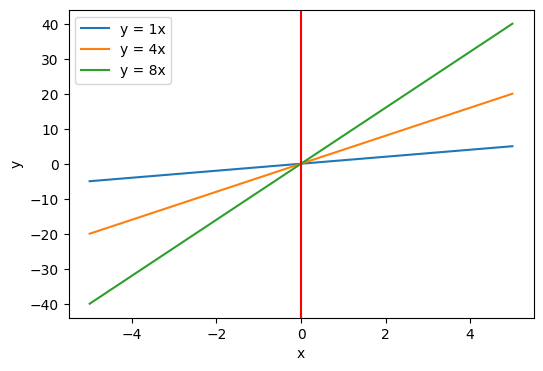

In [ ]:
# все прямые пересекают ось ординат в точке 0
x = np.linspace(-5, 5, 10)
y1 = 1 * x
y2 = 4 * x
y3 = 8 * x

plt.plot(x, y1, label='y = 1x')
plt.plot(x, y2, label='y = 4x')
plt.plot(x, y3, label='y = 8x')
plt.axvline(x=0, ymin=0, ymax=1, c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

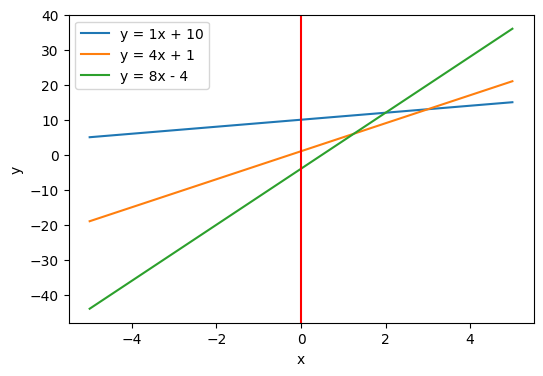

In [ ]:
# прямые пересекают ось ординат в точках b = 10, 1 и -4
x = np.linspace(-5, 5, 10)
y1 = 1 * x + 10
y2 = 4 * x + 1
y3 = 8 * x - 4

plt.plot(x, y1, label='y = 1x + 10')
plt.plot(x, y2, label='y = 4x + 1')
plt.plot(x, y3, label='y = 8x - 4')
plt.axvline(x=0, ymin=0, ymax=1, c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Имеется датасет - зависимость цен на квартиры от их площади  
Задача - построить модель которая предскажет сколько будет стоить квартира площадью 36

| Площадь       | Стоимость  |
| ------------- |:-------------:
| 12 | 8
| 14 | 9
| 8 | 6
| 4 | 6
| 11 | 7
| 10 | 8

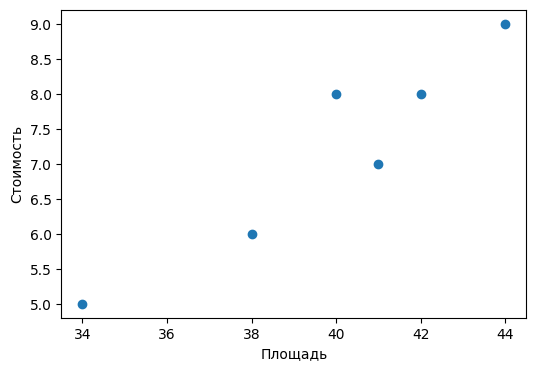

In [ ]:
X = np.array([42, 44, 38, 34, 41, 40])
Y = np.array([8, 9, 6, 5, 7, 8])

plt.scatter(X, Y)
plt.xlabel('Площадь')
plt.ylabel('Стоимость')
plt.show()

Построить прямую $y = wx + b$, проходящую максимально хорошо через точки - чтобы ошибка была минимальной

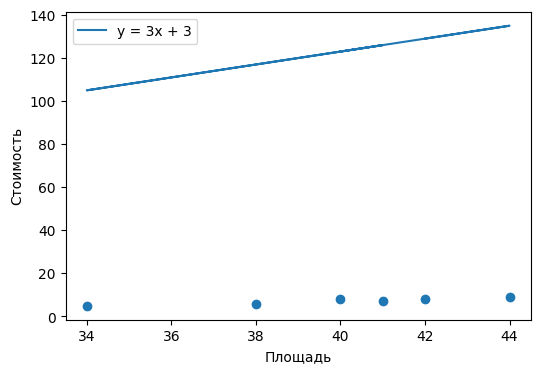

In [ ]:
# случайные параметры линейной регрессии w и b
w = 3
b = 3

# стоимости квартир по мнению модели линейно регрессии
y_pred = w * X + b

plt.plot(X, y_pred, label=f'y = {w}x + {b}')
plt.scatter(X, Y)
plt.xlabel('Площадь')
plt.ylabel('Стоимость')
plt.legend()
plt.show()

Линия плохо описывает данные - плохо предсказывает стоимость.  
Уменьшая `w`, мы сильнее прижимаем прямую к оси `x` - уменьшаем угол наклона прямой

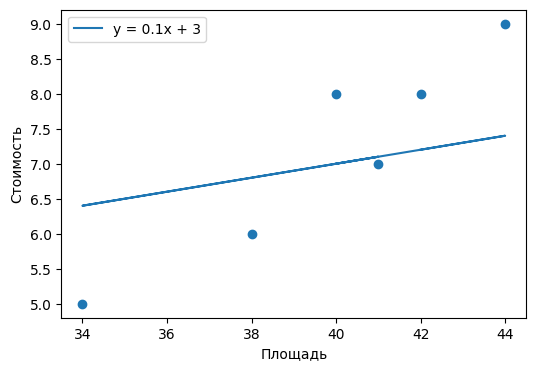

In [ ]:
# взять w поменьше
w = 0.1
b = 3

# посчитать что предсказывает модель при таких параметрах
y_pred = w * X + b

plt.plot(X, y_pred, label=f'y = {w}x + {b}')
plt.scatter(X, Y)
plt.xlabel('Площадь')
plt.ylabel('Стоимость')
plt.legend()
plt.show()

Допустим нас устраивает эта модель при таких параметрах `w` и `b`. Это означает, что чтобы посчитать сколько будет стоить новая квартира площадью 6, мы должны это число подставить в наше уравнение прямой $y = wx + b$, и получить предсказание.  
`0.1 * 36 + 3 = 6`

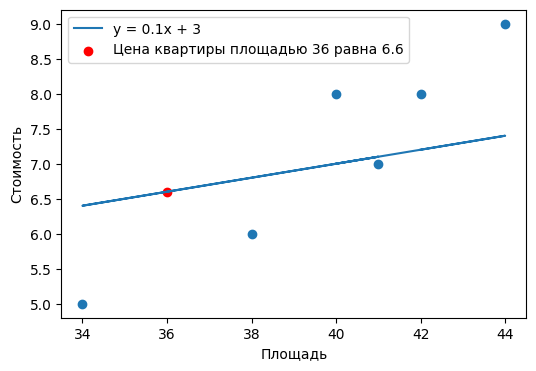

In [ ]:
# площадь новой квартиры - входные данные
x_new = 36

# расчитанная стоимость квартиры- точка по координате y лежащая на прямой wx + b
y_new = w * x_new + b

plt.plot(X, y_pred, label=f'y = {w}x + {b}')
plt.scatter(X, Y)
plt.scatter(x_new, y_new, c='r', label=f'Цена квартиры площадью {x_new} равна {y_new}')
plt.xlabel('Площадь')
plt.ylabel('Стоимость')
plt.legend()
plt.show()

In [ ]:
# реальный стоимость и предсказанная моделью стоимость
Y, y_pred

(array([8, 9, 6, 5, 7, 8]), array([7.2, 7.4, 6.8, 6.4, 7.1, 7. ]))

Cредняя абсолютная ошибка `MAE`

In [ ]:
# MAE - модуль разности между ответами модели и реальными значениями
abs(y_pred - Y)

array([0.8, 1.6, 0.8, 1.4, 0.1, 1. ])

$$
MAE(\hat y, y) = \frac{1}{n} \cdot \sum_{i=1}^n |\hat y - y|
$$

In [ ]:
# усредненная MAE
loss = abs(y_pred - Y).mean()
loss

np.float64(0.9500000000000002)

График MAE функции ошибки  
Поскольку на этот раз функция ошибки зависит от двух переменных - `w` и `b`, то она будет трехмерной - не линией а плоскостью. Для простоты отрисовки пока не будем рисовать трехмерный график, а просто зафиксируем `b` и возьмем список нескольких разных `w`, посчитаем для каждого `w` ошибку, и отрисуем график зависисмости ошибки от переменной `w`

In [ ]:
# список разных w для отрисовки графика
w_list = np.linspace(-1, 1, len(Y))
b = 3

w_list

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

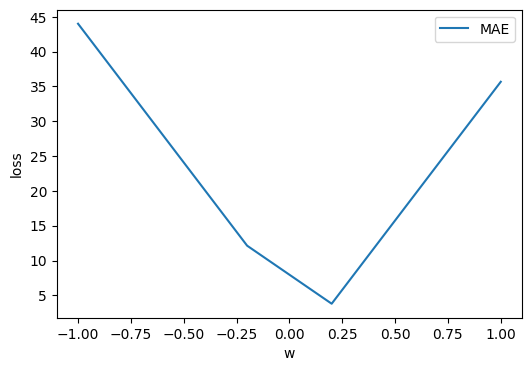

In [ ]:
# список ошибок для отрисовки
losses = []
for w_ in w_list:
    # считаем предсказание модели
    y_pred = w_ * X + b
    # считаем ошибку
    loss = abs(y_pred - Y).mean()
    losses.append(loss)

# отрисовка графика ошибок (немного кривая потому что мало точек для отрисовки - на самом деле она ровная)
plt.plot(w_list, losses, label='MAE')
plt.xlabel('w')
plt.ylabel('loss')
plt.legend()
plt.show()

Видим в какой точке минимум функции ошибки, то есть при каких весах w она минимальна   

Среднеквадратичная ошибка `MSE`

$$
MSE(\hat y, y) = \frac{1}{n} \cdot \sum_{i=1}^n (\hat y - y)^2
$$

In [ ]:
# MSE ошибка
loss = ((y_pred - Y) ** 2).mean()
loss

np.float64(1276.0)

График MSE функции потерь  

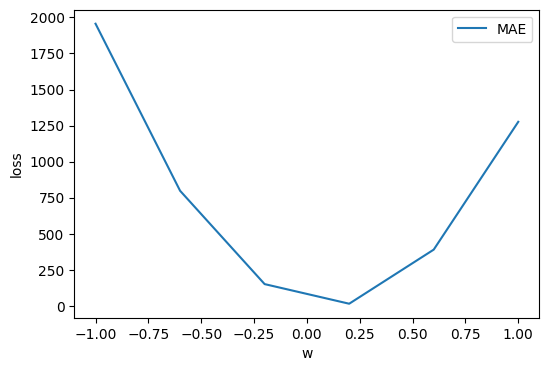

In [ ]:
# список разных w для отрисовки графика
w_list = np.linspace(-1, 1, len(Y))
b = 3

# список ошибок для отрисовки
losses = []
for w_ in w_list:
    # считаем предсказание модели
    y_pred = w_ * X + b
    # считаем ошибку модели
    loss = ((y_pred - Y)**2).mean()
    losses.append(loss)

# отрисовка графика ошибок
plt.plot(w_list, losses, label='MAE')
plt.xlabel('w')
plt.ylabel('loss')
plt.legend()
plt.show()

Найдем минимум функции с помощью градиентного спуска, теперь уже регулируя два параметра - вес `w` и смещение `b`  
Производные для MSE (стр127)  
https://cs.hse.ru/data/2017/11/21/1160780232/Slides-IntroToAI-HSE-2017-06-2-Panov.pdf

Точка w: -14442027.05, Точка b: -360259.27, Ошибка: 69171697832887672.00


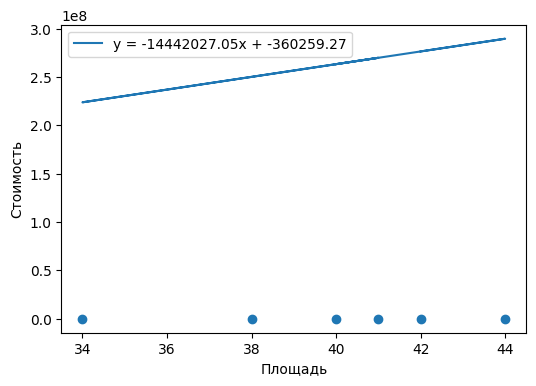

In [ ]:
dots_w = []  # список для отрисовки значений w
w = -2  # начальное приближение веса w
b = 2  # начальное приближение веса - смещения b
learning_rate = 0.001  # скорость обучения

# обучение 20 эпох
for _ in range(20):
    dots_w.append(w)
    y_pred = w * X + b
    loss = ((y_pred - Y)**2).mean()
    # подсчет производных для весов
    dt_dw = 2 * np.sum((Y - y_pred) * -X) / len(Y)  # производная для w
    dt_db = 2 * np.sum(Y - y_pred * -1) / len(Y)  # производная для b
    # корректировка весов
    w -= learning_rate * dt_dw
    b -= learning_rate * dt_db

    # отрисовка результата
    time.sleep(0.1)  # пауза между отрисовками
    clear_output(True)  # очистка вывода
    print(f'Точка w: {w:.2f}, Точка b: {b:.2f}, Ошибка: {loss:.2f}')
    # отрисовка итоговой модели - прямой с новыми весами
    plt.plot(X, y_pred, label=f'y = {w:.2f}x + {b:.2f}')
    plt.scatter(X, Y)
    plt.xlabel('Площадь')
    plt.ylabel('Стоимость')
    plt.legend()
    plt.show()

Значения получились огромными - это называется взрыв градиентов - из за высокой скорости обучения градиенты не уменьшаются а увеличиваются  
Попробуем посторить с уменьшенной скоростью обучения

Точка w: 0.13, Точка b: 2.00, Ошибка: 0.93


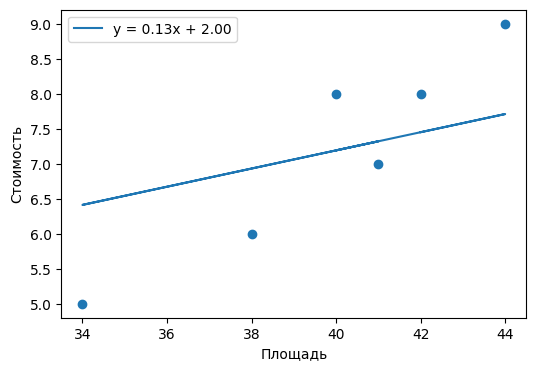

In [ ]:
dots_w = []  # список для отрисовки значений w
w = -2  # начальное приближение веса w
b = 2  # начальное приближение веса - смещения b
learning_rate = 0.0001  # скорость обучения

# обучение 20 эпох
for _ in range(20):
    dots_w.append(w)
    y_pred = w * X + b
    loss = ((y_pred - Y)**2).mean()
    # подсчет производных для весов
    dt_dw = 2 * np.sum((Y - y_pred) * -X) / len(Y)  # производная для w
    dt_db = 2 * np.sum(Y - y_pred * -1) / len(Y)  # производная для b
    # корректировка весов
    w -= learning_rate * dt_dw
    b -= learning_rate * dt_db

    # отрисовка результата
    time.sleep(0.2)  # пауза между отрисовками
    clear_output(True)  # очистка вывода
    print(f'Точка w: {w:.2f}, Точка b: {b:.2f}, Ошибка: {loss:.2f}')
    # отрисовка итоговой модели - прямой с новыми весами
    plt.plot(X, y_pred, label=f'y = {w:.2f}x + {b:.2f}')
    plt.scatter(X, Y)
    plt.xlabel('Площадь')
    plt.ylabel('Стоимость')
    plt.legend()
    plt.show()

Для отрисовки функции ошибки, зависящей от 2х переменных - понадобится трехмерная плоскость

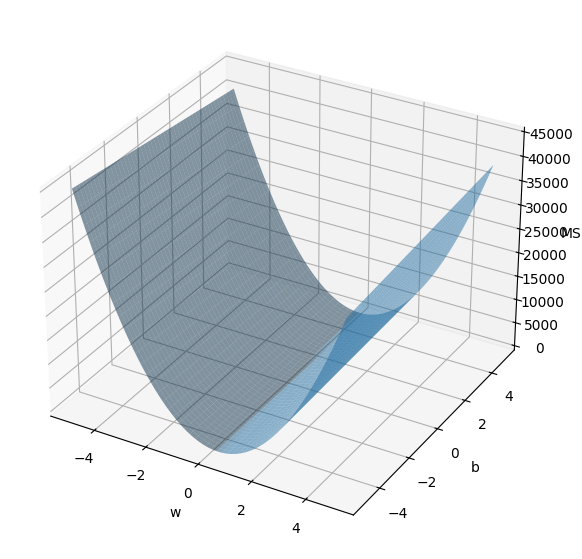

In [ ]:
# массивы для множеств w и b
w_list, b_list = np.linspace(-5, 5, 100), np.linspace(-5, 5, 100)

# сетка точек между ними для отрисовки на трехмерной плоскости
w_list, b_list = np.meshgrid(w_list, b_list, indexing='xy')

loss_list = []
for w, b in zip(w_list.ravel(), b_list.ravel()):
    y_pred = w * X + b
    loss = ((y_pred - Y)**2).mean()
    loss_list.append(loss)

# перобразовать в numpy и задать нужные размер
loss_list = np.array(loss_list)
loss_list = loss_list.reshape(w_list.shape)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')

# чтобы нарисовать плоскость нужны координаты x, y и z
ax.plot_surface(w_list, b_list, loss_list, alpha=.5)

ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('MSE')
plt.show()

Взять случайную точку для `w` и `b`, вычислить для нее ошибку и отрисовать

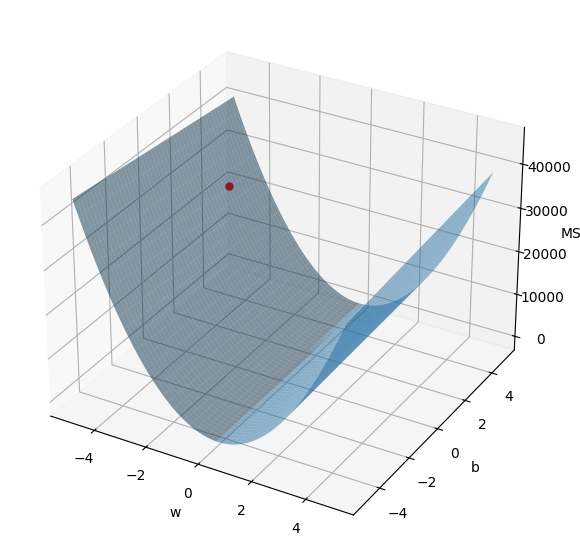

In [ ]:
w = -4
b = 3
y_pred = w * X + b
loss = ((y_pred - Y)**2).mean()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(w_list, b_list, loss_list, alpha=.5)
ax.scatter(w, b, loss, c='r', s=25)

ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('MSE')
plt.show()

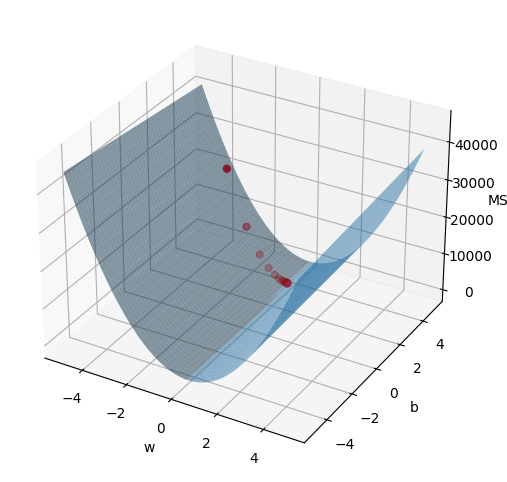

In [ ]:
# начальные w и b случайные
w = -4
b = 3
learning_rate = 0.0001
dots = []
for _ in range(20):
    y_pred = w * X + b
    loss = ((y_pred - Y)**2).mean()
    # вычисление производных
    dt_dw = 2 * np.sum((Y - y_pred) * -X) / len(Y)  # производная для w
    dt_db = 2 * np.sum(Y - y_pred * -1) / len(Y)  # производная для b
    # корректировка весов
    w -= learning_rate * dt_dw
    b -= learning_rate * dt_db
    dots.append([w, b, loss])

dots = np.array(dots)
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(w_list, b_list, loss_list, alpha=.5)
ax.scatter(dots[:, 0], dots[:, 1], dots[:, 2], c='r', s=25)

ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('MSE')
plt.show()

In [ ]:
# итоговые параметры обученной модели
w, b

(np.float64(0.1032615381101547), np.float64(3.0447257924604028))

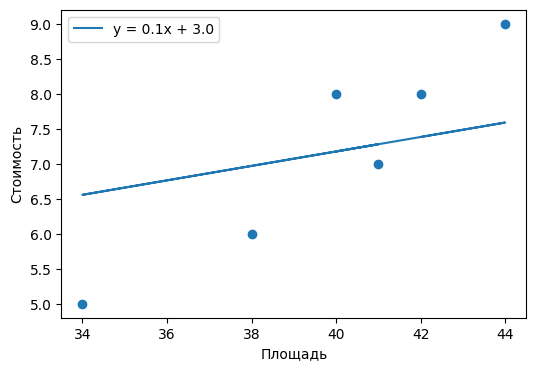

In [ ]:
# проверка модели с новыми обученными параметрами w и b
y_pred = w * X + b

plt.plot(X, y_pred, label=f'y = {w:.1f}x + {b:.1f}')
plt.scatter(X, Y)
plt.xlabel('Площадь')
plt.ylabel('Стоимость')
plt.legend()
plt.show()